In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/functions/')
from Amplitude import Amplitude
from fio import readin

In [2]:
# Helper function 1 that read in one set of parameter with the time given in postfix_index_set
def iter_onecase(postfix_index_set, tag_set, tag_common):
    '''
    postfix_index_set: list of numbers
        A list of corresponding indices used to distinguish the cases.
    tag_set: list of strings
        A list of tags that distinguish each case, can be different from the index set 
    
    '''

    # Instantiate amplitude as a list
    amplitude = []
    
    for i,(index,tag) in enumerate(zip(postfix_index_set, tag_set)):   
        # Use the enhanced read-in function   
        # Rewrite the line according to the file naming 
        # filename = 'filename_common' + '%g' %postfix_index + file_format
        filename = './eta' + '%g' %index
        # Rewrite this line according to the delimiter and the fields attributes
        eta, exists = readin(filename, table_delimiter = ',')
        if exists:
            eta.rename(columns={'pos':'eta'}, inplace=True)
            # Instantiate a amplitude class member
            ampl = Amplitude(eta[['x', 'eta', 'f']])
            amplitude.append(ampl)
    return amplitude, exists

In [3]:
# Helper function 2 that iterates through different parameter set 
def iter_para_newversion(para_pair_set, para_name, common_path, postfix_index, tag):
    amplitude_set = []
    energydirect_set = []
    for p in tqdm(para_pair_set):
        # Assemble the directory name corresponding to each parameter set
        # Example: dirname = './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10'
        dirname = 'linear_m5B0'
        for i,name in enumerate(para_name):
            if name == 'Re':
                dirname += name + '%g' %p[i] + '.'
            else:
                dirname += name + '%g' %p[i]  
        # Change path 
        os.chdir(common_path + dirname)
        # Call iter_onecase, pass directory name as a parameter
        amplitude, exists = iter_onecase(postfix_index_set=postfix_index, tag_set=tag, tag_common = 't = ')
        # If the file does not exceed, do not append
        if exists:
            amplitude_set.append(amplitude)
        energy, exists = readin('budgetWaterwind.dat', table_delimiter = ' ', skipn = 100)
        if exists:
            # HERE IS THE DIFFERENCE! 
            # total = energy.ke/2 + energy.gpe
            total = energy.ke + energy.gpe
            diss = np.zeros(energy.shape[0])
            for i, row in energy.iterrows():
                if i == 0:
                    diss[i] = 0
                    last_t = row['t'] # record t in last row
                else:
                    diss[i] = diss[i-1] + row['dissipation'] * (row['t'] - last_t)
                    last_t = row['t']
            energy.insert(len(energy.columns), "total", total, True)
            energy.insert(len(energy.columns), "total_diss", total+diss, True)
            energydirect_set.append(energy)       
    return amplitude_set, energydirect_set

In [4]:
common_path = '/home/jiarong/research/projects/windwave/'
para_name = ['Ustar','ak','Bo','Re','LEVEL']
para_pair_set, ampl_set, edirect_set = [], [], []
postfix_index = np.arange(0, 1.375, 0.03125)
tag = np.char.mod('%d', postfix_index)
# Add new cases
para_pair_append = [[1.2, 0.05, 0.53, 5000., 9],[1.2, 0.05, 0.53, 5000., 10],[1.2, 0.05, 0.53, 5000., 11]]
# Run with new version (kinetic energy change)
ampl_append, edirect_append = iter_para_newversion(para_pair_append, para_name, common_path, postfix_index, tag)
for para, ampl, edirect in zip(para_pair_append, ampl_append, edirect_append):
    para_pair_set.append(para)
    ampl_set.append(ampl)
    edirect_set.append(edirect)

100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


In [5]:
# para_pair_set, ampl_set, edirect_set = [], [], []
# postfix_index = np.arange(0, 1, 0.03125)
# tag = np.char.mod('%d', postfix_index)
# # Add new cases
# para_pair_append = [[1.1, 0.05, 3.31, 20000., 11],[1.1, 0.05, 3.31, 20000., 12]]
# # Run with new version (kinetic energy change)
# ampl_append, edirect_append = iter_para_newversion(para_pair_append, para_name, common_path, postfix_index, tag)
# for para, ampl, edirect in zip(para_pair_append, ampl_append, edirect_append):
#     para_pair_set.append(para)
#     ampl_set.append(ampl)
#     edirect_set.append(edirect)

In [44]:
# Set the style
from matplotlib import rc
# text and font
## small, medium, large, x-large, xx-large, larger, or smaller
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'large'
# Figure size
plt.rcParams['figure.figsize'] = 8, 4.8 ## figure size in inches
plt.rcParams['figure.dpi'] = 400        ## figure dots per inchfigsize : 6.4, 4.8
# Line
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 10
# Ticks
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['xtick.major.size'] = 3.5
#xtick.major.size     : 3.5    ## major tick size in points
#xtick.minor.size     : 2      ## minor tick size in points
#xtick.major.width    : 0.8    ## major tick width in points
#xtick.minor.width    : 0.6    ## minor tick width in points
#xtick.major.pad      : 3.5    ## distance to major tick label in points
#xtick.minor.pad      : 3.4    ## distance to the minor tick label in points
#xtick.color          : black  ## color of the tick labels
#xtick.labelsize      : medium ## fontsize of the tick labels
#xtick.direction      : out    ## direction: in, out, or inout
#xtick.minor.visible  : False  ## visibility of minor ticks on x-axis
# Legend
#legend.scatterpoints : 1        ## number of scatter points
#legend.markerscale   : 1.0      ## the relative size of legend markers vs. original
#legend.title_fontsize  : None ## None sets to the same as the default axes.

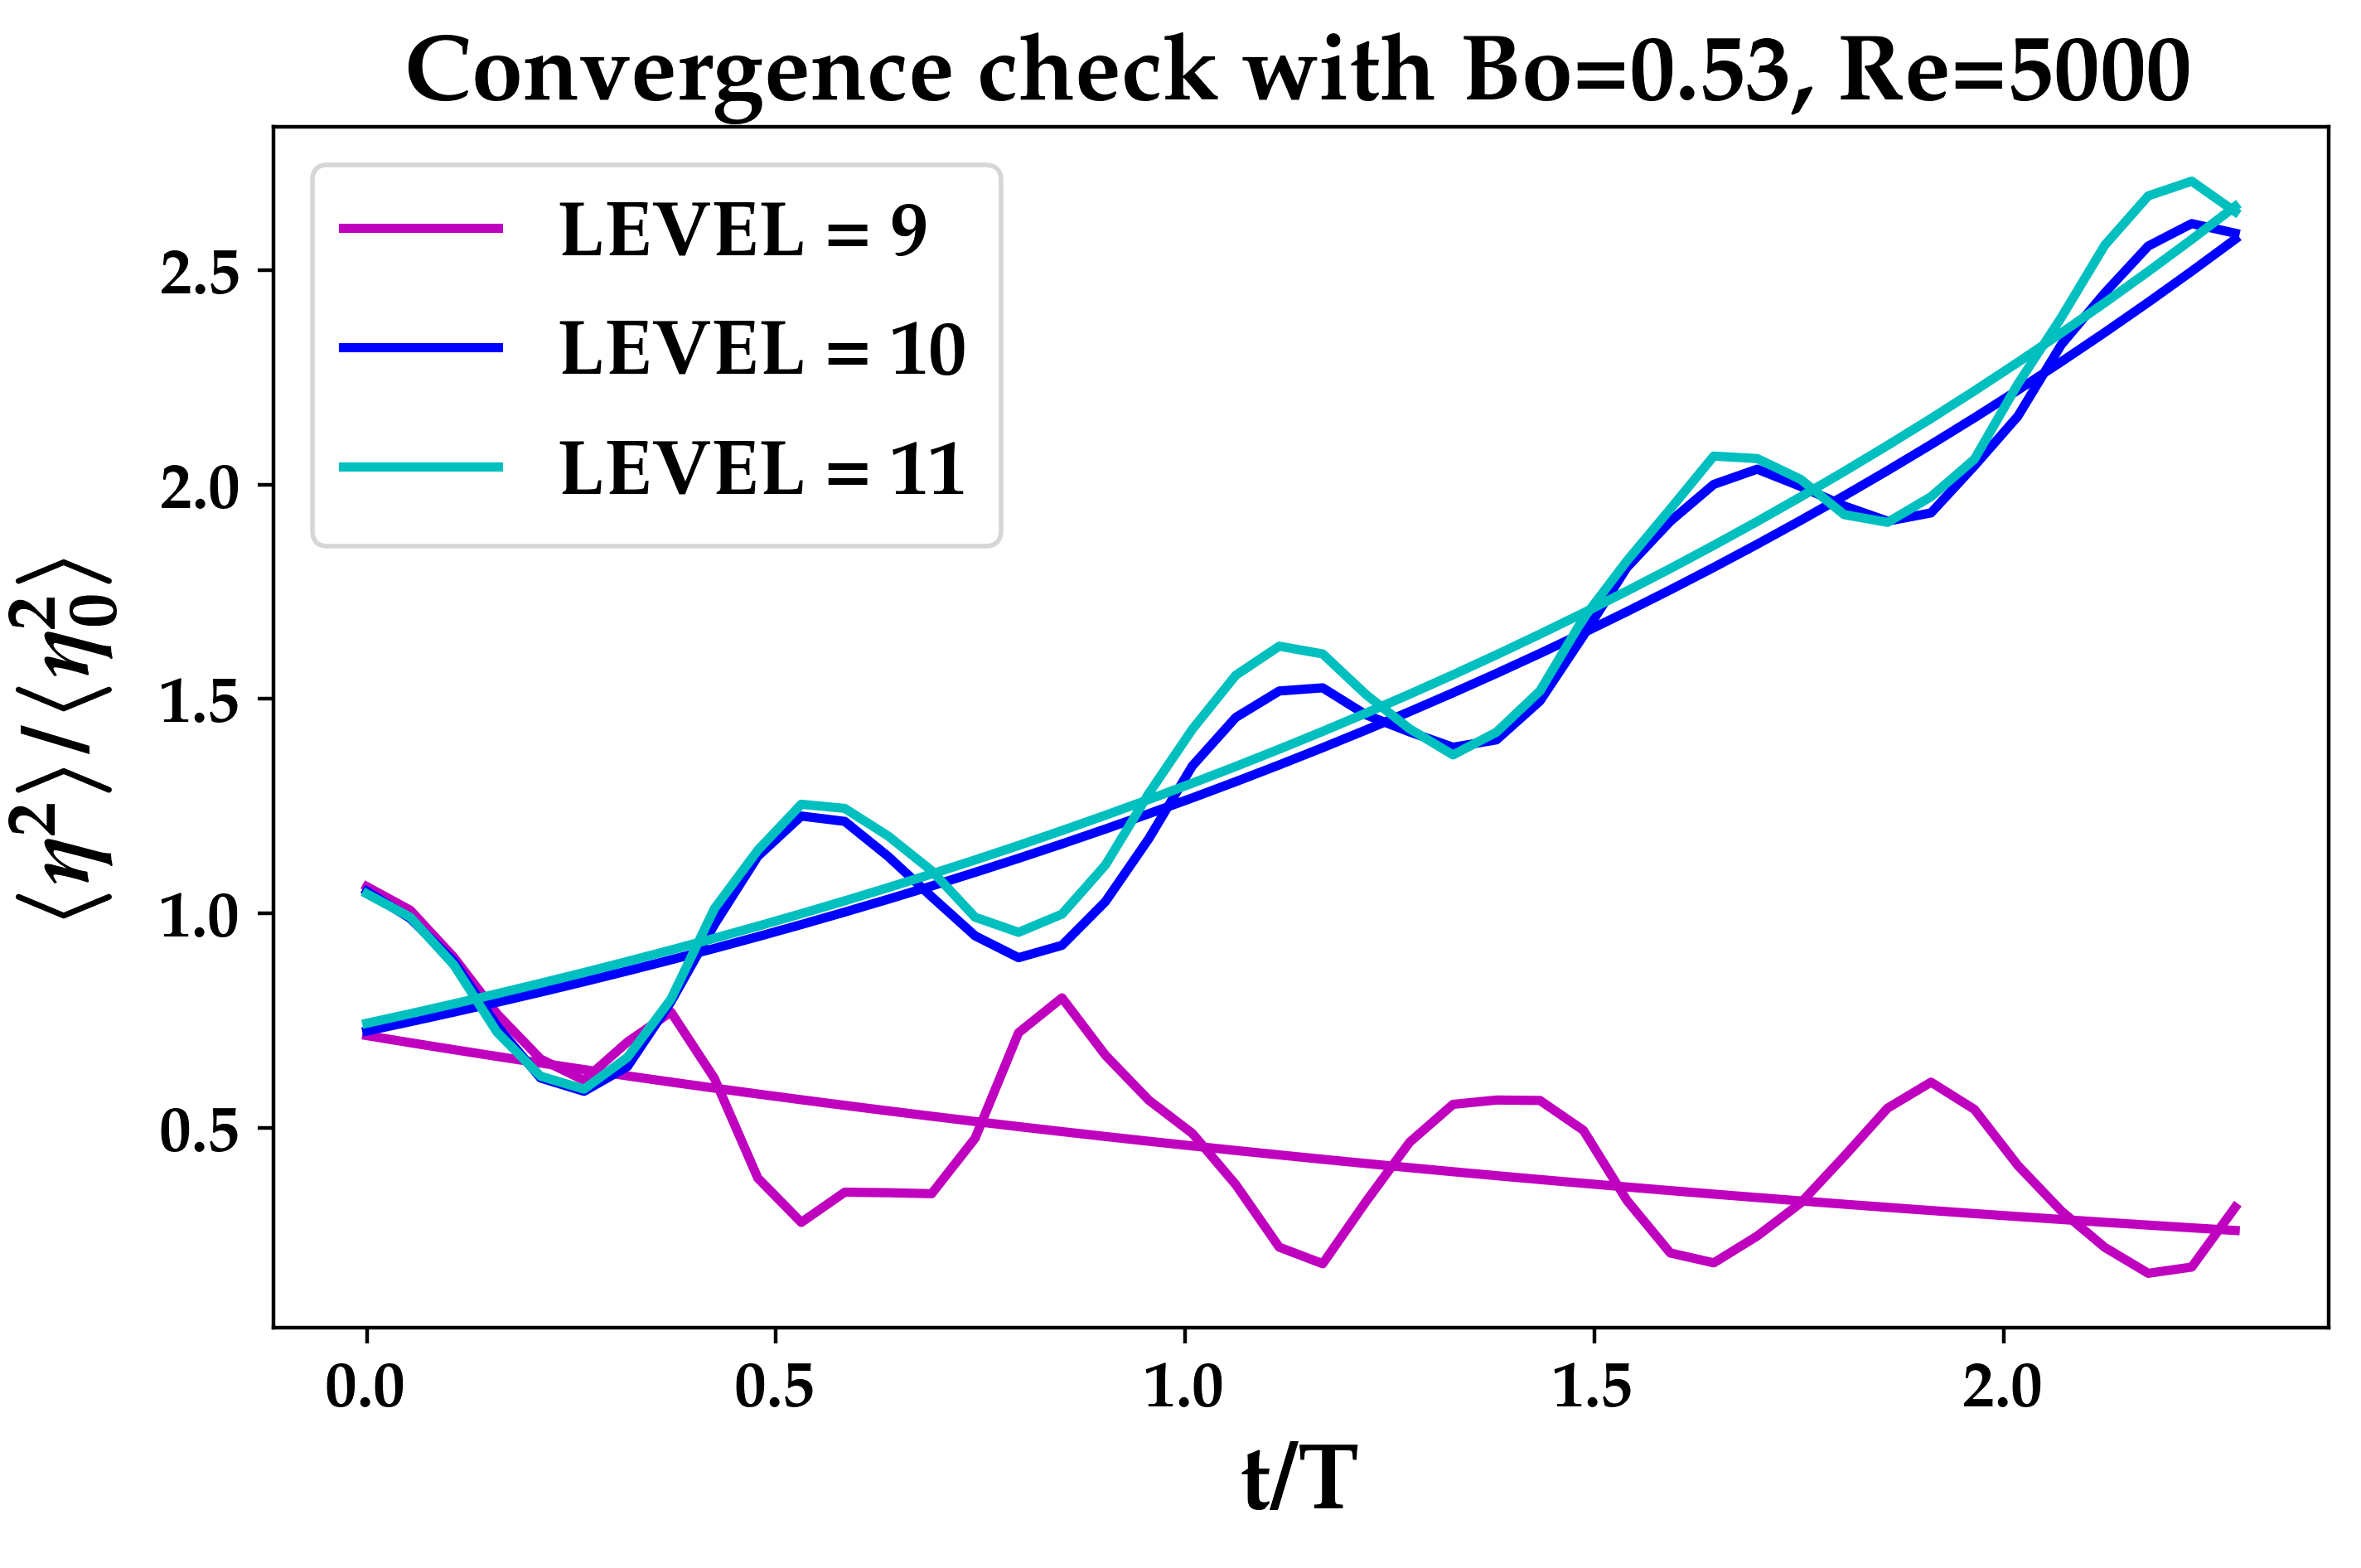

In [46]:
fig = plt.figure()
ax1 = fig.gca()
para_tag = np.char.mod('%d', para_pair_set[0])
# Time was scaled!!!
time = postfix_index * (2*np.pi)**0.5
colorchoice = ['m','b','c']

def plot(ampl_subset, para_pair_subset, edirect_subset):
    ustar,beta_std,nondim_beta_std,beta_std_partial,nondim_beta_std_partial = [],[],[],[],[]
    for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
        y = np.array([ampl.stdev**2/2 for ampl in amplitude])
        # compute wave frequency omega = (self.g*self.k + self.sigma*self.k**3/self.rho)**0.5
        omega = (2*np.pi*(1+1/para[2]))**0.5;  std0 = 1.5*10**(-5)
        ax1.plot(time/(2*np.pi/omega), y/std0, label = r'\textbf{LEVEL = %g}' %para[4], color=colorchoice[i])
        # exponential fit for below 4 times the initial amplitude
        t_partial,y_partial = [],[]
        for index,t in enumerate(time):
            if y[index]/std0 <= 4:
                t_partial.append(t); y_partial.append(y[index])
        a, b = np.polyfit(np.array(t_partial), np.log(np.array(y_partial)), 1)
        beta_std_partial.append(a)
        nondim_beta_std_partial.append(a/omega)
        ax1.plot(time/(2*np.pi/omega), np.exp(b)*np.exp(a*time)/std0, color=colorchoice[i])
    ax1.set_xlabel(r'\textbf{t/T}')
    ax1.set_ylabel(r'$\langle \eta^{2} \rangle / \langle \eta^{2}_{0} \rangle$')

    return np.array(ustar), np.array(beta_std), np.array(nondim_beta_std)

ilist = np.arange(0,3)
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
a, b, nondim = plot(ampl_subset, para_pair_subset, edirect_subset)

ax1.legend()
ax1.set_title(r"\textbf{Convergence check with Bo=0.53, Re=5000}")
fig.savefig('/home/jiarong/research/presentation/APSDFD/LEVEL.pdf', bbox_inches='tight')